# Donkey Car Dataset Diversification

## Notebook Context

This notebook focuses on the impact of diverse datasets (Not more data, not enough ram yet - will think of a way to compress the images like they did with the CIFAR-10 dataset) on model performance. 

Data will be randomly extracted from three pools - the generated track set, the generated road set, and the warehouse set. The model is then trained with this diverse dataset (Consisting of only the generated track and generated road - the warehouse dataset is a blind test dataset) and tested on each of these three environments as was done with the baseline establishment testing loop. This will probably only show that if the model has seen it before, it will perform on it again. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Step 1: Dataset Retrieval and Management
The Dataset used for this experiment is found in the mounted Google Drive folder (if not mounted, contact me and we can try sort it out). The dataset consists of images, and json labels for those images. The json labels contain the driving angle as floating point values in the range of -1 and 1. -1 means all the way left, and 1 means all the way to the right. We are not addressing throttle labels in this experiment. 


In [2]:
#!mkdir ./AllCombo
#Mount Data Folder From Google Drive: - using only path0 as test set. path1 and path2 are fully training sets
path0 = "./GenTrack5Throttle/"
path1 = "./DefRoad5Throttle/"
path2 = "./WH5Throttle/"


In [ ]:
!unzip '/content/drive/My Drive/DIYRobocars_2020/Data/DonkeyGymData_Jul2020/GenTrack5Throttle.zip'
!unzip '/content/drive/My Drive/DIYRobocars_2020/Data/DonkeyGymData_Jul2020/WH5Throttle.zip'
!unzip '/content/drive/My Drive/DIYRobocars_2020/Data/DonkeyGymData_Jul2020/DefRoad5Throttle.zip'

In [4]:
#Import required packages for this step:
%tensorflow_version 1.x
import os   #For retrieving files
import natsort #For sorting retrieved files
import numpy as np #Calculations, arrays, etc.
import cv2 #Image preprocessing, loading and saving images
import json #For processing json files
import tensorflow as tf  #For the ML side
from random import randrange 

import matplotlib.pyplot as plt #Plots


#Make sure plots happen inline


%matplotlib inline

TensorFlow 1.x selected.


In [7]:
#Donkey Training and Val data splits
def train_test_split(data_list,label_list, label2_list, shuffle=True, test_size=0.3):
    '''
    take a list, split it into two sets while selecting a 
    random element in order to shuffle the results.
    use the test_size to choose the split percent.
    shuffle is always True, left there to be backwards compatible
    '''
    assert shuffle
    data_list = list(data_list)
    label_list = list(label_list)
    label2_list = list(label2_list)
    train_data = []
    traina_labels =[]
    traint_labels =[]

    target_train_size = len(data_list) * (1. - test_size)

    i_sample = 0

    while i_sample < target_train_size and len(data_list) > 1:
        i_choice = np.random.randint(0, len(data_list) - 1)
        train_data.append(data_list.pop(i_choice))
        traina_labels.append(label_list.pop(i_choice))
        traint_labels.append(label2_list.pop(i_choice))
        i_sample += 1

    # remainder of the original list is the validation set
    val_data = data_list
    vala_labels = label_list
    valt_labels = label2_list
    del data_list
    del label_list
    del label2_list
    return val_data, train_data, vala_labels, traina_labels, valt_labels, traint_labels

In [5]:
#Function to set aside testing data from the two training sets, since they will be
#shuffled into each other and we can't just straight up use 

def testaside(data_list, label_list, test_size=0.3):
    target_train_size = len(data_list) * (1. - test_size)
    train_data = []
    train_labels = []
    i_sample = 0

    while i_sample < target_train_size and len(data_list) > 1:
        i_choice = np.random.randint(0, len(data_list) - 1)
        train_data.append(data_list.pop(i_choice))
        train_labels.append(label_list.pop(i_choice))
        i_sample += 1

    # remainder of the original list is the test set
    test_data = data_list
    test_labels = label_list
    return train_data, test_data, train_labels, test_labels

In [8]:
#Fetch data for training - If Going with Diversification
images_0 =[]
images_1 = []

train_images = []
val_images = []

images0 = []
labels0 = []

images1 = []
labels1 = []

images = []
labels = []


label_0 = []
label_1 = []

train_labels = []
val_labels = []
#Collect images into respective lists:

for file in os.listdir(path0):
    if 'cam' in file:
        images0.append(path0+file)
    elif 'record' in file:
        labels0.append(path0+file)
images0 = natsort.natsorted(images0)
labels0 = natsort.natsorted(labels0)
images0, testd0, labels0, testl0 = testaside(images0, labels0) #Set aside track data for testing model

images.extend(images0)
labels.extend(labels0)

for file in os.listdir(path1):
    if 'cam' in file:
        images1.append(path1+file)
    elif 'record' in file:
        labels1.append(path1+file)
images1 = natsort.natsorted(images1)
labels1 = natsort.natsorted(labels1)
images1, testd1, labels1, testl1 = testaside(images1, labels1) #Set aside road data for testing model

images.extend(images1)
labels.extend(labels1)


xvall = [] 
xtrainl = [] 
yvalal = []
ytrainal = [] 
yvaltl = []
ytraintl = []
images = natsort.natsorted(images)
labels = natsort.natsorted(labels)
xvall, xtrainl, yvalal, ytrainal, yvaltl, ytraintl = train_test_split(images,labels, labels) 



print("Train labels and images order check:")
print(xtrainl[10])
print(ytrainal[10])

print("Val labels and images order check:")
print(xvall[10])
print(yvalal[10])


print("test labels and images order check:")
print(testd0[10])
print(testl0[10])


print("test labels and images order check:")
print(testd1[10])
print(testl1[10])

Train labels and images order check:
./GenTrack5Throttle/14653_cam-image_array_.jpg
./GenTrack5Throttle/record_14653.json
Val labels and images order check:
./DefRoad5Throttle/68_cam-image_array_.jpg
./DefRoad5Throttle/record_68.json
test labels and images order check:
./GenTrack5Throttle/37_cam-image_array_.jpg
./GenTrack5Throttle/record_37.json
test labels and images order check:
./DefRoad5Throttle/37_cam-image_array_.jpg
./DefRoad5Throttle/record_37.json


In [ ]:
#Fetch Data For Training - If going for single dataset (vanilla, single dataset canny)
path = path0

images_0 =[]

train_images = []
val_images = []

images = []
labels = []

label_0 = []

train_labels = []
val_labels = []
#Collect images into respective lists:

for file in os.listdir(path):
    if 'cam' in file:
        images.append(path+file)
    elif 'record' in file:
        labels.append(path+file)

xvall = [] 
xtrainl = [] 
yvalal = []
ytrainal = [] 
yvaltl = []
ytraintl = []
images = natsort.natsorted(images)
labels = natsort.natsorted(labels)
xvall, xtrainl, yvalal, ytrainal, yvaltl, ytraintl = train_test_split(images,labels, labels) 


print("Train labels and images order check:")
print(xtrainl[10])
print(ytrainal[10])

print("Val labels and images order check:")
print(xvall[10])
print(yvalal[10])


Train labels and images order check:
./GenTrack5Throttle/2010_cam-image_array_.jpg
./GenTrack5Throttle/record_2010.json
Val labels and images order check:
./GenTrack5Throttle/36_cam-image_array_.jpg
./GenTrack5Throttle/record_36.json


In [14]:
#ROI:
#ROI
def ROI(image):
  image = np.asarray(image, dtype=np.uint8)
  width = 120
  height = 160
  factor = 2.4
  factor2 = 1.15
  #imageb = cv.blur(image,(10,10))
  image[0:int(round(width/factor)),:,:] = 0
  image[int(round(width/factor2)):,:,:] = 0
  return image


#Thresholding:
def Thresh(image, Block=11, Const=2):
  image = np.asarray(image, dtype=np.uint8)
  image[:,:,0]= cv.adaptiveThreshold(image[:,:,0],255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv.THRESH_BINARY,Block,Const)
  image[:,:,1]= cv.adaptiveThreshold(image[:,:,1],255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv.THRESH_BINARY,Block,Const)
  image[:,:,2]= cv.adaptiveThreshold(image[:,:,2],255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv.THRESH_BINARY,Block,Const)
  
  image = image/255
  #ROI
  width = 120
  height = 160
  factor = 2.4
  factor2 = 1.15
  #imageb = cv.blur(image,(10,10))
  image[0:int(round(width/factor)),:,:] = 0
  image[int(round(width/factor2)):,:,:] = 0
  return image

#Adaptive Canny Edge Detection
def AdaptCanny(image,gray, Block=11, Const=2):
  image = np.asarray(image, dtype=np.uint8)
  imagec = image.copy()
  grayscale = cv.cvtColor(imagec, cv.COLOR_RGB2GRAY)
  imagec[:,:,0]= cv.adaptiveThreshold(grayscale,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv.THRESH_BINARY,Block,Const)
  imagec[:,:,1]= cv.adaptiveThreshold(grayscale,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv.THRESH_BINARY,Block,Const)
  imagec[:,:,2]= cv.adaptiveThreshold(grayscale,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv.THRESH_BINARY,Block,Const)
  canny = cv.Canny(imagec,50,220, L2gradient=True)
  image = image/255
  imagec = imagec/255
  canny = canny/255
  image[:,:,0] = canny
  image[:,:,1] = canny
  image[:,:,2] = canny
  
  #ROI
  width = 120
  height = 160
  factor = 2.4
  factor2 = 1.15
  #imageb = cv.blur(image,(10,10))
  image[0:int(round(width/factor)),:,:] = 0
  image[int(round(width/factor2)):,:,:] = 0
  return image

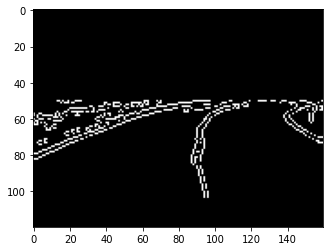

In [ ]:
import cv2 as cv

#Testing Image Manips:

image = cv.imread(xtrainl[100])
image_average = np.mean(image)
block = int(round(0.1*image_average))
if np.mod(block,2) != 1:
  block += 1
image = AdaptCanny(image, block, -0.17*image_average)
plt.imshow(image)
plt.show()

In [ ]:
try:
  del xtrain
  del ytraina
  del ytraint
  del xval
  del yvala
  del yvalt
except:
  print("No Things to Delete")


#Directly reading data into val data split to save RAM

import cv2 as cv

maxspeed = 0.25 #Adjust per battery level. High Battery: 0.25, Medium Battery: 0.35, Low Battery: 0.45
speed_adjust = maxspeed/0.05 #FACTOR WITH WHICH TO ADJUST SPEED FOR PHYSICAL CAR (ranges from 0.25/.05 to 0.45/.05 depending on
#battery levels)

angle_adjust = 0.1 #Adjust each angle with +10% of that angle. (FOR FRICTION! :grin:)

width = 120 #set image width
height = 160 #set image height
color = 3  #set colour channels
dim = (width, height) #Create dimension tuple


#Read Images and Labels into arrays:

xtrain = np.zeros((len(xtrainl), 120, 160, 3), dtype=np.float32)
xval = np.zeros((len(xvall), 120, 160, 3), dtype=np.float32)

ytraina = np.zeros(len(ytrainal), dtype=np.float32)
ytraint = np.zeros(len(ytraintl), dtype=np.float32)

yvala = np.zeros(len(yvalal),dtype=np.float32)
yvalt = np.zeros(len(yvaltl),dtype=np.float32)


for i in range(len(xtrainl)):
    xtrain[i,:,:,:] = cv.imread(xtrainl[i])
    xtrain[i] = cv.cvtColor(xtrain[i], cv.COLOR_BGR2RGB)
    gray = cv.cvtColor(xtrain[i], cv.COLOR_RGB2GRAY)
    image_average = np.mean(gray)
    block = int(round(0.1*image_average))
    if np.mod(block,2) != 1:
      block += 1
    xtrain[i] = AdaptCanny(xtrain[i], gray,block, -0.17*image_average)
    #xtrain[i] = Thresh(xtrain[i], block, -0.17*image_average)
    #xtrain[i] = ROI(xtrain[i])
    #xtrain[i] = xtrain[i]/255 #Normalise between 0 and 1 - better for tf
    with open(ytrainal[i]) as file:
        jdata = json.load(file)
        ytraina[i] = jdata['user/angle'] + angle_adjust*(jdata['user/angle'])  #angle data
        if ytraina[i] > 1.0:
          ytraina[i] = 1.0
    with open(ytraintl[i]) as file:
        jdata = json.load(file)    
        ytraint[i] = jdata['user/throttle']*speed_adjust #throttle data

for i in range(len(xvall)):
    xval[i,:,:,:] = cv.imread(xvall[i])
    xval[i] = cv.cvtColor(xval[i], cv.COLOR_BGR2RGB)
    gray = cv.cvtColor(xval[i], cv.COLOR_RGB2GRAY)
    image_average = np.mean(gray)
    block = int(round(0.1*image_average))
    if np.mod(block,2) != 1:
      block += 1
    xval[i] = AdaptCanny(xval[i], gray,block, -0.17*image_average)
    #xval[i] = Thresh(xval[i], block, -0.17*image_average)
    #xval[i] = ROI(xval[i])
    #xval[i] = xval[i]/255 #Normalise between 0 and 1 - better for tf
    with open(yvalal[i]) as file:
        jdata = json.load(file)
        yvala[i] = jdata['user/angle'] + angle_adjust*(jdata['user/angle'])  #angle data with adjustment for friction
        if ytraina[i] > 1.0:
          ytraina[i] = 1.0
    with open(yvaltl[i]) as file:
        jdata = json.load(file)
        yvalt[i] = jdata['user/throttle']*speed_adjust #throttle data

print("NewSpeed:")
print(yvalt[i])
print("File Check:")
image = cv.imread(xvall[250])
plt.imshow(image)
plt.show()
plt.imshow(xval[250])
plt.show()
print(yvala[10])
print(yvalt[10])
with open(yvalal[10]) as file:
    tdata = json.load(file)
    print(tdata['user/angle'])
with open(yvaltl[10]) as file:
    tdata = json.load(file)
    print(tdata['user/throttle'])
    
print(xvall[10])
print(yvalal[10])

### Step 2: Set up Network and Experiment
Regression CNN as set up in Phase 1 of experimentation and design.

This is also where the Neptune experiment setup begins. This will follow mostly the same style as found in the Donkey Toy Experiment notebook. The Neptune experiment tracker for the littlefoot project can be found at https://ui.neptune.ai/charag/Littlefoot/experiments?viewId=standard-view. Currently, we are tracking the validation loss and accuracy of the default setup, and are comparing variations in layer amounts, layer sizes, kernel sizes, and other parameters that will be listed. 

This experiment set will be tagged DefaultCNN and DiverseCanny in Neptune.

In [16]:
import os
os.environ['NEPTUNE_API_TOKEN'] = 'eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiOTgyNzBkM2EtMzZhNC00NDkwLWJiNmEtNDJiYzQ0ZDRjZWNkIn0='

In [ ]:

#Neptune experiment initialization:
try:
   import neptune
except:
  !pip install neptune-client
  import neptune
#Import neptune and initialise tracking of an experiment

neptune.init(
    api_token=None,
    project_qualified_name="charag/Littlefoot"
) #API Token is set to environment variable and the project name littlefoot is selected


#Enable logging in a neptune experiment - define keras callbacks and create a neptune logger class

from tensorflow.keras.callbacks import Callback

class NeptuneLogger(Callback):

    def on_batch_end(self, batch, logs={}): #Log metrics after every batch
        for log_name, log_value in logs.items():
            neptune.log_metric(f'batch_{log_name}', log_value)

    def on_epoch_end(self, epoch, logs={}): #log metrics after every epoch
        for log_name, log_value in logs.items():
            neptune.log_metric(f'epoch_{log_name}', log_value)


#Experiment Parameters:

OPTIMIZER = 'adam' #stochastic gradient descent
LOSS = 'mse' #absolute error from the value desired
#LOSS = 'mae'
EPOCH = 300
BATCH = 132
KERNEL1 = 5
KERNEL2 = 3
STRIDE = 2
CONVLAYERS = 6
DENSELAYERS = 4
POOLLAYERS = 1
PRUNING = "dropout"
FeatureEng = "ROI,Canny"
Dataset = "GenTrack"
BatteryLevel = "High"


In [ ]:
#Start Experiment:
#, Canny, 40-120 thresholds, Thresholding at 230 each channel, Blur with 5x5 Kernel
neptune.create_experiment(name='Base CNN Training for Physical Implementation',
                          params={'epochs': EPOCH,
                                  'batch_size': BATCH,
                                  'Optimization' : OPTIMIZER,
                                  'LOSS': LOSS,
                                  'Dataset' : Dataset,
                                  'FeatureEngineering': FeatureEng},         
                          tags=['Base_CNN', 'Diversification',FeatureEng, Dataset, BatteryLevel],
                          description="Diverse data, Feature Engineering")


https://ui.neptune.ai/charag/Littlefoot/e/LIT-318


Experiment(LIT-318)

In [ ]:
# Imports: Tensorflow 1.14.0 is used
%tensorflow_version 1.x

import os
import numpy as np

from tensorflow.python import keras
from tensorflow.python.keras.layers import Input, Dense
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Convolution2D, Convolution1D, MaxPooling2D, Reshape, BatchNormalization
from tensorflow.python.keras.layers import Activation, Dropout, Flatten, Cropping2D, Lambda


In [ ]:
#Model Structure Setup:
drop = 0.10
num_outputs = 2

img_in = Input(shape=(120,160,3), name='img_in')
x = img_in
x = Convolution2D(12, (3,3), strides=(2,2), activation='relu')(x)
x = Convolution2D(24, (3,3), strides=(2,2), activation='relu')(x)
x = Dropout(drop)(x)
x = Convolution2D(32, (3,3), strides=(2,2), activation='relu')(x)
x = Dropout(drop)(x)
x = MaxPooling2D(3,1,padding='valid')(x)
x = Convolution2D(64, (3,3), strides=(2,2), activation='relu')(x)
x = Dropout(drop)(x)
x = Convolution2D(64, (3,3), strides=(1,1), activation='relu')(x)
x = Dropout(drop)(x)
x = Convolution2D(128, (3,3), strides=(2,2), activation='relu')(x)
x = Flatten()(x)
x = Dense(1000, activation='relu')(x)
x = Dense(500, activation='relu')(x) 
x = Dense(250, activation='relu')(x)
x = Dense(100, activation='relu')(x)
x = Dense(50, activation='relu')(x)

outputs = []
    
for i in range(num_outputs):
    outputs.append(Dense(1, activation='linear', name='n_outputs' + str(i))(x))
        
model = Model(inputs=[img_in], outputs=outputs)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
#Compile Model 
model.compile(optimizer=OPTIMIZER,
    loss=LOSS)

model.summary()

NameError: ignored

In [ ]:
#Name Model
modelname = 'GenTrackCannyPhysical_LowBattery_LIT-318.h5'

In [ ]:
#Fit Model to Data
EarlyStop = keras.callbacks.EarlyStopping(monitor='val_n_outputs0_loss', patience=50)
save_best = keras.callbacks.ModelCheckpoint(modelname, monitor='val_n_outputs0_loss', verbose=1, save_best_only=True, mode='min')
#model.fit(x_train, y_train, epochs=EPOCH, batch_size=BATCH, validation_data=(x_val, y_val),callbacks=[NeptuneLogger(), EarlyStop, save_best], shuffle=True, verbose=1)


model.fit(xtrain, [ytraina, ytraint], epochs=EPOCH, batch_size=BATCH, validation_data=(xval, [yvala, yvalt]),callbacks=[NeptuneLogger(), EarlyStop, save_best], shuffle=True, verbose=1)
neptune.log_artifact(modelname)
neptune.stop()

## STEP 3: Validate Your Model
After the experiment has completed, select a random image/label pair with which to run a prediction, or even a set of these predictions, to have a tangible vision of how the model performs.

In [ ]:
test_data = []
test_labels = []

patht = path2

for file in os.listdir(patht):
  if "cam" in file:
    test_data.append(patht+file)
  elif "record" in file:
    test_labels.append(patht+file)


In [ ]:
#Load Test Datasets - if using diversified testing data

try:
  del xval
  del yvala
  del yvalt
  del xtrain
  del ytraina
  del ytraint
  
except:
  try:
    del x_test
    del y_testa
    del y_testt
  except:
    print("No Things to Delete")

#Import Image from Pillow
from PIL import Image
import cv2 as cv
test_data = natsort.natsorted(test_data)
test_labels = natsort.natsorted(test_labels)


#Create Images array:

width = 120 #set image width
height = 160 #set image height
color = 3  #set colour channels
dim = (width, height) #Create dimension tuple

#Initialise images array:
if patht == path0:
  test_data = testd0
  test_labels = testl0
elif patht == path1:
  test_data = testd1
  test_labels = testl1

x_test = np.zeros((len(test_labels), width, height, color), dtype = np.float32)

print(x_test.shape)
for i in range(len(test_data)):
    filename = test_data[i]
    x_test[i,:,:,:] = cv2.imread(filename)
    image_average = np.mean(x_test[i])
    block = int(round(0.1*image_average))
    if np.mod(block,2) != 1:
      block += 1
    x_test[i] = AdaptCanny(x_test[i], block, -0.17*image_average)
    #x_test[i] = Thresh(x_test[i], block, -0.17*image_average)
    #x_test[i] = ROI(x_test[i])
    #x_test[i] = x_test[i]/255


#read angle labels into y_angle array
json_data = {}
y_testa = np.zeros(len(test_labels), dtype=np.float32) #setup label array 
y_testt = np.zeros(len(test_labels), dtype=np.float32) #setup label array 

for i in range(len(test_labels)):
    filename = test_labels[i]
    with open(filename) as fp:
        json_data = json.load(fp)
        orient = json_data['user/angle']
        y_testa[i] = orient
        vroom = json_data['user/throttle']*speed_adjust #remember to even adjust speed for testing data!
        y_testt[i] = vroom

plt.imshow(x_test[100])
plt.show()

(13060, 120, 160, 3)


In [ ]:
#Load Test Datasets - If we are using only a single dataset:

if (patht != path):
  try:
    del xval
    del yvala
    del yvalt
  except:
    print("No Things to Delete")
else:
  print("Testing on Validation Dataset - ", path)

try:
  del xtrain
  del ytraina
  del ytraint
  
except:
  try:
    del x_test
    del y_testa
    del y_testt
  except:
    print("No Things to Delete")

#Import Image from Pillow
from PIL import Image
import cv2 as cv
test_data = natsort.natsorted(test_data)
test_labels = natsort.natsorted(test_labels)


#Create Images array:

width = 120 #set image width
height = 160 #set image height
color = 3  #set colour channels
dim = (width, height) #Create dimension tuple

#Initialise images array:
if patht == path:
  x_test = xval
  y_testa = yvala
  y_testt = yvalt
else:
  x_test = np.zeros((len(test_labels), width, height, color), dtype = np.float32)

  print(x_test.shape)
  for i in range(len(test_data)):
      filename = test_data[i]
      x_test[i,:,:,:] = cv2.imread(patht+filename)
      image_average = np.mean(x_test[i])
      block = int(round(0.1*image_average))
      if np.mod(block,2) != 1:
        block += 1
      x_test[i] = AdaptCanny(x_test[i], block, -0.17*image_average)
      #x_test[i] = Thresh(x_test[i], block, -0.17*image_average)
      #x_test[i] = x_test[i]/255
      #x_test[i] = AdaptCanny(x_test[i],65,-20)
      #x_test[i] = Thresh(x_test[i],65,-20)
      #x_test[i] = ROI(x_test[i])/255

#read angle labels into y_angle array
  json_data = {}
  y_testa = np.zeros(len(test_labels), dtype=np.float32) #setup label array 
  y_testt = np.zeros(len(test_labels), dtype=np.float32) #setup label array 

  for i in range(len(test_labels)):
      filename = test_labels[i]
      with open(patht+filename) as fp:
          json_data = json.load(fp)
          orient = json_data['user/angle']
          y_testa[i] = orient
          vroom = json_data['user/throttle']
          y_testt[i] = vroom

plt.imshow(x_test[100])
plt.show()

NameError: ignored

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Evaluation on  ./DefRoad5Throttle/


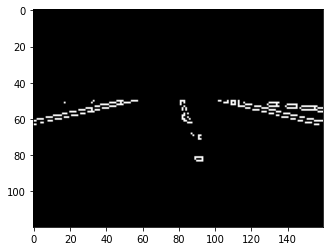

Label:
0.05701921
13060/13060 [==============================] - 2s 187us/sample - loss: 0.0288 - n_outputs0_loss: 0.0226 - n_outputs1_loss: 0.0062
[[0.15010409]
 [0.15010409]
 [0.15010409]
 ...
 [0.15516636]
 [0.14915234]
 [0.14915234]]
(2, 13060)
result:
0.05180013
0.15104571
0.10956539838042846
Prediction Accuracy
0.8626687843263537
Percentage Deviation
0.13733121567364626
Mean Absolute Error
0.1095654
Root Mean Squared Error
0.15044212078934802
R2 Score
0.11582863706532265


In [ ]:
modelname = 'DiverseCannyPhysical_LowBattery_LIT-308.h5'
ModelBest = keras.models.load_model(modelname)
BATCH=132
num = randrange(len(x_test))
print("Evaluation on ", path1)
#Select Random Image and Label to show as examples
plt.imshow(x_test[num])
plt.show()

pred_im = x_test[num]
pred_label = y_testa[num]

print("Label:")
print(pred_label)

#Model prediction
diff = np.zeros(len(y_testa))
perc = np.zeros(len(y_testa))


#label_out = model.predict(x_val, batch_size=BATCH,verbose=1)
label_out = ModelBest.predict(x_test, batch_size=BATCH,verbose=1)
ModelBest.evaluate(x_test, [y_testa, y_testt], batch_size=BATCH, verbose=1)
print(label_out[1])
label_out = np.asarray(label_out)
label_out=np.squeeze(label_out)
print(label_out.shape)
for i in range(0, len(y_testa)):
  diff[i] = abs(y_testa[i] - label_out[0,i])
  perc[i] = (np.max(y_testa)-diff[i])/np.max(y_testa)
#model.save('LIT-16.h5')
print("result:")
print(label_out[0,num])
print(label_out[1,num])
print(np.sum(diff)/len(diff))
print("Prediction Accuracy")
print(np.sum(perc)/len(perc))
print("Percentage Deviation")
print(1-np.sum(perc)/len(perc))


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from math import sqrt

rmse = sqrt(mean_squared_error(y_testa, label_out[0]))
mae = mean_absolute_error(y_testa, label_out[0])
r2 = r2_score(y_testa, label_out[0])
print("Mean Absolute Error")
print(mae)
print("Root Mean Squared Error")
print(rmse)
print("R2 Score")
print(r2)


In [ ]:
#Mountain Pass Data Val
